## Zadanie 1
Napisz implementacje funkcji loss bazując na poprzednim notebooku, a następnie porównaj loss dla zdjęcia org z zdjęciami b1 ... b5.
Zrób wykresy ilustrujące loss względem każdego z zdjęć

Text(0, 0.5, 'Losses')

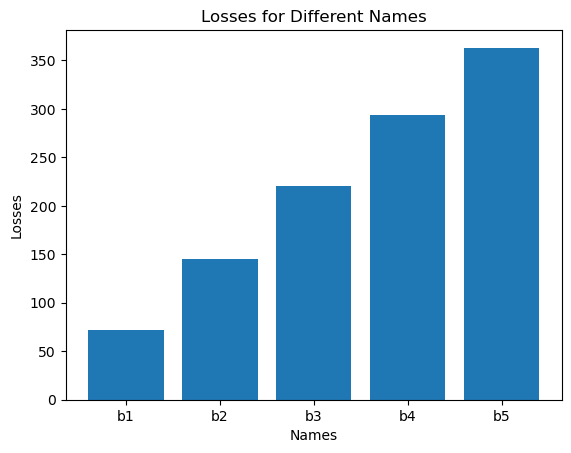

In [1]:
import torch
import matplotlib.pyplot as pyplot
from PIL import Image
from torchvision import transforms

# Load original image
org = Image.open('elza/org.jpg') 
transform = transforms.Compose([transforms.PILToTensor()]) 
org_tensor = transform(org)
losses = []
names = []
for i in range(1,6):
    name = 'b'+ str(i)
    src = 'elza/'+ name +'.jpg'
    copy = Image.open(src) 
    copy_tensor = transform(copy)
    
    # Make sure the two images have the same dimensions
    assert copy_tensor.shape == org_tensor.shape, "Images must have the same dimensions!"
    
    # Compute MSE
    mse_loss = torch.nn.functional.mse_loss(org_tensor.float(), copy_tensor.float())
    losses.append(mse_loss)
    names.append(name)
    
fig, ax = pyplot.subplots()
ax.bar(names, losses)
ax.set_title('Losses for Different Names')
ax.set_xlabel('Names')
ax.set_ylabel('Losses')


## Zadanie 2
Napisz i wytrenuj prosty model którego zadaniem bedzie klasyfikacja czy punkt znajduje sie wewnątrz koła jednostkowego czy może poza nim.
Następnie spróbuj użyć Fourier Feature do zmapowania wejścia. 
Poeksperymentuj z różnymi rodzajami transformacji ( parametr L oraz mnożenie przez macierz B)
Wyniki zilustruj wykresami

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import optim

L = 10  
N = 1000 
E = 500

train = np.random.uniform(-2., 2., (N, 2))
label_train = np.zeros(N)

for i in range(N):
    if np.linalg.norm(train[i]) < 1.0:
        label_train[i] = 1

data_train = torch.tensor(train, dtype=torch.float32)
data_label_train= torch.tensor(label_train, dtype=torch.float32)

test_size = N//6

test = np.random.uniform(-2., 2., (test_size, 2))
label_test = np.zeros(test_size)

for i in range(test_size):
    if np.linalg.norm(test[i]) < 1.0:
        label_test[i] = 1

data_test = torch.tensor(test, dtype=torch.float32)
data_label_test= torch.tensor(label_test, dtype=torch.float32)

In [3]:
class FourierNet(nn.Module):
    def __init__(self, L):
        super(FourierNet, self).__init__()
        self.L = L
        self.B = torch.randn(2*L)  # Change this line
        self.fc1 = nn.Linear(4*L, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        stacked = []
        for i in range(self.L):
            stacked.append(torch.sin(2. * np.pi * x * self.B[2*i]))  # Use element-wise multiplication here
            stacked.append(torch.cos(2. * np.pi * x * self.B[2*i + 1]))  # Use element-wise multiplication here
        x = torch.cat(stacked, dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class RegularNet(nn.Module):
    def __init__(self):
        super(RegularNet, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

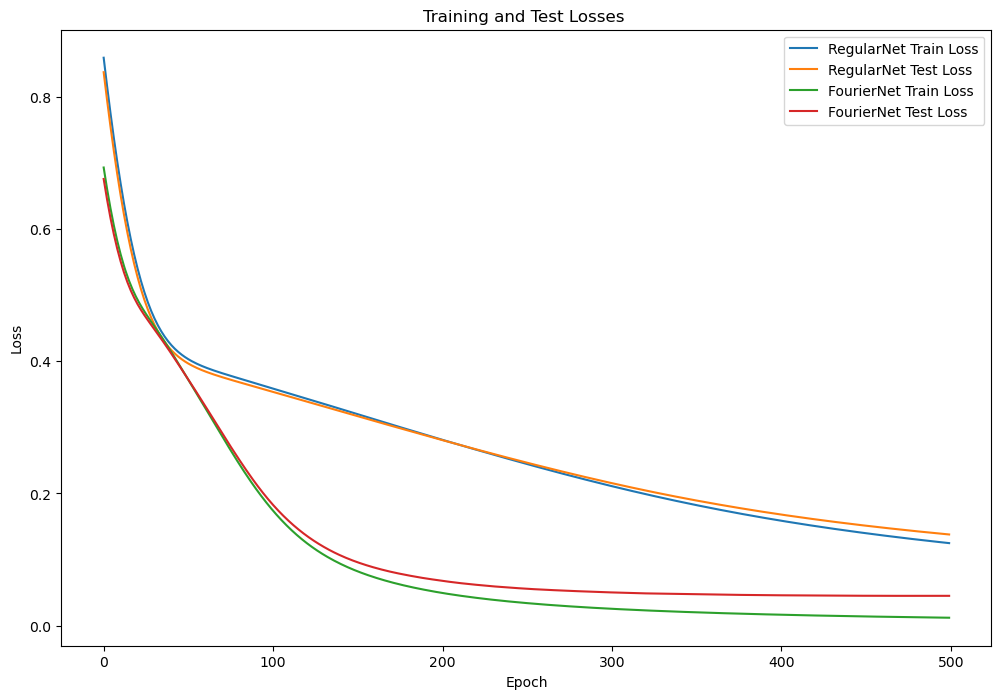

In [5]:

reg = RegularNet()
criterion_reg = torch.nn.BCELoss() 
optimizer_reg = optim.Adam(reg.parameters(), lr=0.001)
train_loss_reg = []
test_loss_reg = []

for epoch in range(E):
    outputs = reg(data_train)
    loss = criterion_reg(outputs.squeeze(), data_label_train)
    train_loss_reg.append(loss.item())
    loss.backward()
    optimizer_reg.step()

    optimizer_reg.zero_grad()
    
    with torch.no_grad():
        outputs_test = reg(data_test)
        loss_test = criterion_reg(outputs_test.squeeze(), data_label_test).item()
        test_loss_reg.append(loss_test)
    

fourier = FourierNet(L)
criterion_fourier = torch.nn.BCELoss() 
optimizer_fourier = optim.Adam(fourier.parameters(), lr=0.001)
train_loss_fourier = []
test_loss_fourier = []

for epoch in range(E):
    outputs = fourier(data_train)
    loss = criterion_fourier(outputs.squeeze(), data_label_train)
    train_loss_fourier.append(loss.item())

    loss.backward()
    optimizer_fourier.step()  

    optimizer_fourier.zero_grad()  
    
    with torch.no_grad():
        outputs_test = fourier(data_test)
        loss_test = criterion_fourier(outputs_test.squeeze(), data_label_test).item()
        test_loss_fourier.append(loss_test)
    

plt.figure(figsize=(12, 8))

plt.plot(train_loss_reg, label='RegularNet Train Loss')
plt.plot(test_loss_reg, label='RegularNet Test Loss')

plt.plot(train_loss_fourier, label='FourierNet Train Loss')
plt.plot(test_loss_fourier, label='FourierNet Test Loss')

plt.title('Training and Test Losses ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Zadanie 3
Napisz i wytrenuj 2 modele których zadaniem bedzie zapamiętanie zdjęcia. Jeden z nich niech wykorzystuje Fourier Feature a drugi nie.
Zdjęciem które bedzie należy zapamietać jest org_smaller.jpg
Dla modelu bez FF proponuje następującą strukture:
Conv2d( 2,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,3,kernel_size=1,padding=0)
Sigmoid()

dla modelu z FF proponuje taki model: (trzeba z 2 wejść zrobić 256)
Conv2d( 256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,3,kernel_size=1,padding=0)
Sigmoid()

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

org = Image.open('org_smaller.jpg') 
transform = transforms.Compose([transforms.ToTensor()]) 
elza = transform(org).permute(1,2,0)

def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

    return tensor


cpu


/var/folders/5p/l6byzth96sq3xcyy0dt0cvxr0000gn/T/ipykernel_44459/3305423002.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(elza).unsqueeze(0).permute(0, 3, 1, 2).to(device)


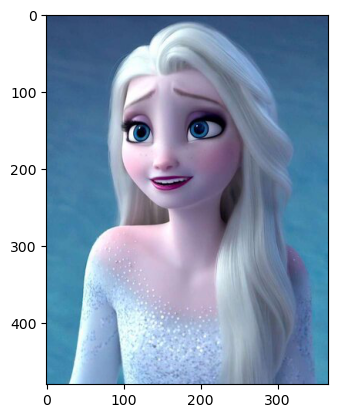

In [35]:
target = torch.tensor(elza).unsqueeze(0).permute(0, 3, 1, 2).to(device)
plt.imshow(tensor_to_numpy(target[0]))
plt.show()

coordsw = np.linspace(0, 1, target.shape[2], endpoint=False)
coordsh = np.linspace(0, 1, target.shape[3], endpoint=False)
xy_grid = np.stack(np.meshgrid(coordsh, coordsw), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

0
Epoch 0, loss = 0.207


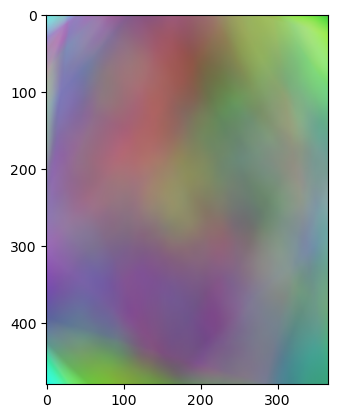

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Epoch 100, loss = 0.095


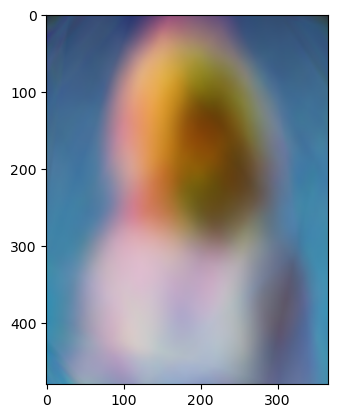

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Epoch 200, loss = 0.074


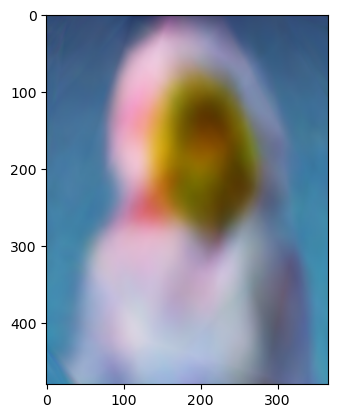

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
Epoch 300, loss = 0.063


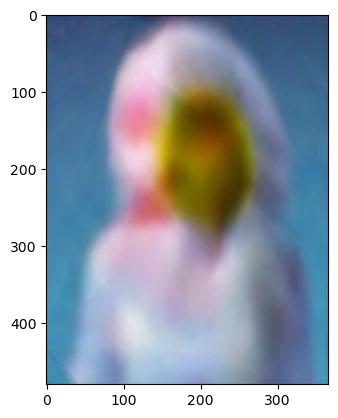

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399


In [36]:
import torch.nn as nn

class ImageRemember(nn.Module):
    def __init__(self):
        super(ImageRemember, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 256, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 3, kernel_size=1, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return x

imageModel = ImageRemember().to(device)

optimizer = torch.optim.Adam(list(imageModel.parameters()), lr=1e-4)

for epoch in range(800):
    optimizer.zero_grad()

    generated = imageModel(xy_grid)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(tensor_to_numpy(generated[0]))
      plt.show()

In [38]:
class GaussianFourierFeatureTransform(torch.nn.Module):
    def __init__(self, num_input_channels, mapping_size=256, scale=10):
        super().__init__()

        self._num_input_channels = num_input_channels
        self._mapping_size = mapping_size
        self._B = torch.randn((num_input_channels, mapping_size)) * scale

    def forward(self, x):
        assert x.dim() == 4, 'Expected 4D input (got {}D input)'.format(x.dim())

        batches, channels, width, height = x.shape

        assert channels == self._num_input_channels,\
            "Expected input to have {} channels (got {} channels)".format(self._num_input_channels, channels)

        x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)

        x = x @ self._B.to(x.device)

        x = x.view(batches, width, height, self._mapping_size)
        x = x.permute(0, 3, 1, 2)

        x = 2 * np.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

Epoch 0, loss = 0.214


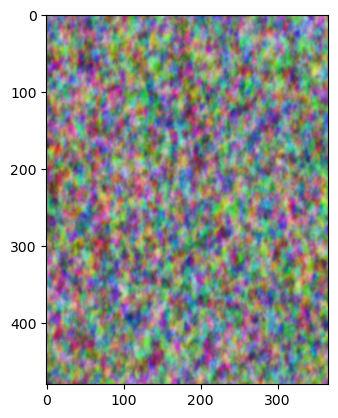

Epoch 100, loss = 0.074


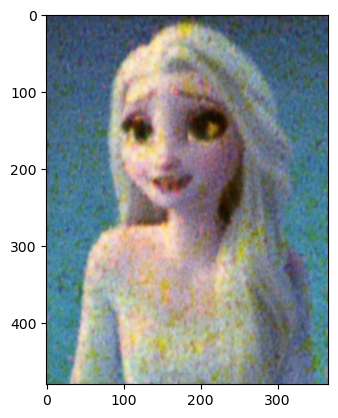

In [39]:
K_SIZE = 256

class FurierImageRemember(nn.Module):
    def __init__(self):
        super(FurierImageRemember, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(K_SIZE, K_SIZE, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(K_SIZE))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(K_SIZE, K_SIZE, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(K_SIZE))

        self.layer3 = nn.Sequential(
            nn.Conv2d(K_SIZE, K_SIZE, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(K_SIZE))

        self.layer4 = nn.Sequential(
            nn.Conv2d(K_SIZE, 3, kernel_size=1, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return x

fourier = FurierImageRemember().to(device)

# Note: this can be done outside of the training loop, since the result at this stage is unchanged during the course of training.
x = GaussianFourierFeatureTransform(2, K_SIZE//2, 10)(xy_grid)

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

for epoch in range(600):
    optimizer.zero_grad()

    generated = fourier(x)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(tensor_to_numpy(generated[0]))
      plt.show()
